### HW 4, Part 2, Start
### CSCI 4270 and 6270, Spring 2024

This is starter code for HW 4, Part 2. Most important is the definition of the Dataset object for loading, separately, the train, validation and test image sets. Students can use as much or as little of this as they wish and can modify it in anyway they'd like

In [1]:
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os 
import random


In [2]:
def is_image(fn):
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if os.path.isfile(file_path) and is_image(filename):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths

folder_path = "hw4_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)


Returing 150 image paths


In [3]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 50
batch_size = 16
learning_rate = 0.005

In [4]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''
class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i
    
class HW4_DataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size):
        super().__init__(dataset, batch_size=batch_size, shuffle=True, collate_fn=None)
        
        
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset("hw4_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset("hw4_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset("hw4_data/test", class_names, new_size=new_size, verbose=verbose)

# Form Dataloaders
train_dataloader = HW4_DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = HW4_DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = HW4_DataLoader(test_dataset, batch_size=batch_size)

Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 2
Image shape is (240, 360, 3)


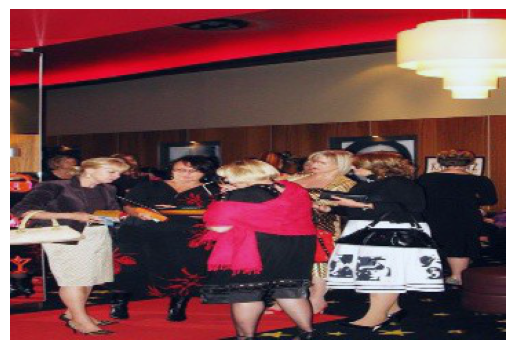

2


In [5]:
'''
Explore the constructed dataset
'''

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

In [6]:
# Build Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_stack = nn.Sequential(
           nn.Conv2d(3, 16, 3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(4,4),
           nn.Conv2d(16, 32, 3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(4,4),
           nn.Conv2d(32, 32, 3, stride=1, padding=1),
           nn.ReLU(),
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*15*22, 128),
            nn.ReLU(),
            nn.Linear(128, 72),
            nn.ReLU(),
            nn.Linear(72, 5),
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits


model = ConvNet().to(device)
print(model)

ConvNet(
  (conv_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10560, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=72, bias=True)
    (4): ReLU()
    (5): Linear(in_features=72, out_features=5, bias=True)
  )
)


In [7]:
def test(dataloader, model, loss_fn):
    model.eval() 
    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            _, predicted = torch.max(pred.data, 1)
            
            # Store predictions
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(y.cpu().numpy())         
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total

    test_pairs = list(zip(all_preds, all_labels))
    return accuracy, test_pairs


def compute_per_class_accuracy(test_pairs, class_names):
    pred, label = zip(*test_pairs)
    num_classes = len(class_names)
    counts_per = np.zeros(num_classes)
    num_correct = np.zeros(num_classes)

    for i in range(len(test_pairs)):
        counts_per[label[i]] += 1
        if pred[i] == label[i]:
            num_correct[label[i]] += 1
    
    per_class_acc = num_correct / counts_per

    # Output results
    print("Per class accuracy")
    for i, acc in enumerate(per_class_acc):
        print(f'{class_names[i]}: {acc:4.2f}')

    return per_class_acc


def compute_confusion_matrix(test_pairs, class_names):
    pred, label = zip(*test_pairs)
    num_classes = len(class_names)
    
    cm = confusion_matrix(pred, label)

    print(f'\nConfusion matrix')
    for i in range(num_classes):
        print(f'{i:2d}:', end='')
        for j in range(num_classes):
            print(f' {cm[i, j]:2d}', end='')
        print()

    return cm


In [8]:
def train(model, loss_fn, optimizer):
    model.train()

    best_train_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Get train loss at end of epoch
            if batch == batch_size-1:
                train_loss = loss.item()

        # Check if this is new best model based on train loss
        if train_loss < best_train_loss:
            best_train_loss = train_loss

            val_accuracy = test(valid_dataloader, model, loss_fn)[0]

            print(f"New best model found at epoch {epoch}")
            print(f"Training Loss: {best_train_loss:.6f}")
            print(f"Validation Accuracy: {val_accuracy:>0.1f}%\n")

    model.eval()
    print('Finished Training')

In [9]:
# Train the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer)

# Compute accuracy measures (Final test)
test_accuracy, test_pairs = test(test_dataloader, model, loss_fn)
print(f"Accuracy of the model on the test images: {test_accuracy:>0.1f}%\n")

compute_per_class_accuracy(test_pairs, class_names)
compute_confusion_matrix(test_pairs, class_names)

# Save the model
PATH = './cnn_model.pth'
torch.save(model.state_dict(), PATH)


New best model found at epoch 0
Training Loss: 1.608204
Validation Accuracy: 33.5%

New best model found at epoch 1
Training Loss: 1.597157
Validation Accuracy: 51.3%

New best model found at epoch 2
Training Loss: 1.408506
Validation Accuracy: 68.3%

New best model found at epoch 3
Training Loss: 0.969993
Validation Accuracy: 77.9%

New best model found at epoch 4
Training Loss: 0.587660
Validation Accuracy: 80.7%

New best model found at epoch 5
Training Loss: 0.570431
Validation Accuracy: 76.8%

New best model found at epoch 6
Training Loss: 0.406834
Validation Accuracy: 81.9%

New best model found at epoch 8
Training Loss: 0.168057
Validation Accuracy: 82.4%

New best model found at epoch 15
Training Loss: 0.113286
Validation Accuracy: 82.1%

New best model found at epoch 37
Training Loss: 0.079788
Validation Accuracy: 84.7%

New best model found at epoch 43
Training Loss: 0.023302
Validation Accuracy: 81.5%

Finished Training
Accuracy of the model on the test images: 83.9%

Per cl

# Discussion

I begin my implentation by configuring the pytorch device the network work will run on, cpu by default or cuda if available. I then define the hyperparameters of num_epochs, batch_size and learning_rate. Next I included a slight modification to the provided code to read in the dataset. I convert each HW4_dataset object into a pytorch Dataloader object with no other modification. This is in order to run the .to method to send data to my cuda device during training.

After exploring the data, I then define my convolutional network. My architecture includes three conv layers, two 4x4 pooling layers and three dense layers. I then define my testing and training loop functions similar to the given lecture code. After training my model on the full sized images with hyperparameters of: num_epochs = 50, batch_size = 16, learning_rate = 0.005, my model. This was the best performing set of hyperparameters I found.

The model achieves an accuracy of 82.4% on the test images.  It achieves a per class accuracy of: 
grass: 0.79, ocean: 0.73, redcarpet: 0.95, road: 0.85, wheatfield: 0.81. The model clearly works best on classifying redcarpet images and worst on ocean images. The confusion matrix shows: Grass and wheatfield are often confused. Also Road also seems to be commonly misclassified as grass or ocean. These results might indicate similarity in the features.
